# Run OCR Pipeline

## Init
define here all constant variables

In [ ]:
sys_path = r'C:\Users\sgala\PycharmProjects\OCR' # path to project
path_to_tesstrain_code = r"C:\Users\sgala\Documents\python_projects\tesseract\tesstrain" #download from https://github.com/tesseract-ocr/tesstrain/tree/main and follow instructions
#recomended - watch: https://www.youtube.com/watch?v=SvhoBT-PnME&ab_channel=SL7Tech
relative_path_to_starting_model = '../tessdata/' #default tesstrain data folder
tesseract_exe_path = r"C:\Program Files\Tesseract-OCR\tesseract.exe" #install tesseract from: https://github.com/UB-Mannheim/tesseract/wiki
tessdata_path = r"C:\Program Files\Tesseract-OCR\tessdata\script" #in tesseract folder after install
bash_path = r"C:/Program Files/Git/bin/bash.exe" #path to a bash on your computer (problem in windows mostly)

In [1]:
import shutil
import sys
sys.path += [sys_path]
from generate_pdfs.create_pdf_dataset import create_pdf_dataset
from tesseract.prepare_train_data import pdf_to_train_images
from tesseract.prepare_validation_data import process_pdf_to_images_and_data
from tesseract.metrics import evaluate_ocr_batch
import pytesseract
import pandas as pd
import os
import cv2
import subprocess
import numpy as np


pytesseract.pytesseract.tesseract_cmd = tesseract_exe_path
os.environ["TESSDATA_PREFIX"] = tessdata_path

## Pipeline config
    define all the pipeline parameters:
    for every stage - weather to do that stage and also all its parameters

In [2]:
generate_pdfs = True
pdfs_dir = r"C:\Users\sgala\OCR\pipeline\random_pdfs"
n_files = 100
train_eval_ratio = 0.9
prepare_train_data = True
train_data_dir = r"C:\Users\sgala\OCR\pipeline\train_dataset"
augment = False
prepare_eval_data = True
eval_data_dir = r"C:\Users\sgala\OCR\pipeline\eval_dataset"
train_model=True
model_name = "heb_random_top_five_hundred" #apperently cannot contain numbers, go figure
model_dir = r"C:\Users\sgala\OCR\pipeline"

eval_model=True




## Generate pdfs

In [3]:
if generate_pdfs:
    create_pdf_dataset(pdfs_path=pdfs_dir,
                       corpus_path=r'C:\Users\sgala\PycharmProjects\OCR\generate_pdfs\top_500_words.csv',
                       n_files=n_files)
    

Generating PDF with font arial...
Generating PDF with font ahronbd...
Generating PDF with font tahoma...
Generating PDF with font courbd...
Generating PDF with font tahomabd...
Generating PDF with font calibrib...
Generating PDF with font calibrili...
Generating PDF with font calibril...
Generating PDF with font courbd...
Generating PDF with font ahronbd...
Generating PDF with font davidbd...
Generating PDF with font timesbd...
Generating PDF with font calibrii...
Generating PDF with font timesbi...
Generating PDF with font calibrib...
Generating PDF with font calibril...
Generating PDF with font calibrili...
Generating PDF with font calibri...
Generating PDF with font david...
Generating PDF with font calibri...
Generating PDF with font calibril...
Generating PDF with font CascadiaMono...
Generating PDF with font calibriz...
Generating PDF with font calibril...
Generating PDF with font calibrili...
Generating PDF with font calibrib...
Generating PDF with font calibri...
Generating PDF

## Prepare train eval data

In [4]:
from glob import glob
if prepare_train_data or prepare_eval_data:
    all_paths = glob(pdfs_dir+"\*.pdf")
    ratio_index = int(len(all_paths)*train_eval_ratio)
    train_paths = all_paths[:ratio_index]
    eval_paths = all_paths[ratio_index:]

    for tp in train_paths:
        pdf_to_train_images(tp, train_data_dir, augment=augment) #dpi?
    for ep in eval_paths:
        process_pdf_to_images_and_data(ep, output_dir=eval_data_dir)

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_0_page1_line12.png
created image C:\Users\sgala\OCR\pipeline\train_d

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_14_page1_line12.png
created image C:\Users\sgala\OCR\pipe

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_2_page1_line12.png
created image C:\Users\sgala\OCR\pipeline\train_d

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_25_page1_line12.png
created image C:\Users\sgala\OCR\pipe

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_30_page1_line12.png
created image C:\Users\sgala\OCR\pipe

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_36_page1_line12.png
created image C:\Users\sgala\OCR\pipe

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_41_page1_line12.png
created image C:\Users\sgala\OCR\pipe

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_47_page1_line12.png
created image C:\Users\sgala\OCR\pipe

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line13.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line14.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_52_page1_line15.png
created image C:\Users\sgala\OCR\pi

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_58_page1_line12.png
created image C:\Users\sgala\OCR\pipe

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_63_page1_line12.png
created image C:\Users\sgala\OCR\pipe

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_69_page1_line12.png
created image C:\Users\sgala\OCR\pipe

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_74_page1_line12.png
created image C:\Users\sgala\OCR\pipe

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line12.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_8_page1_line13.png
created image C:\Users\sgala\OCR\pipeline\train_

created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line1.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line2.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line3.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line4.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line5.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line6.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line7.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line8.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line9.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line10.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line11.png
created image C:\Users\sgala\OCR\pipeline\train_dataset\text_85_page1_line12.png
created image C:\Users\sgala\OCR\pipe

Processing completed. Images saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset', and data saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset/text_90_output_data.json'.
Processing completed. Images saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset', and data saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset/text_91_output_data.json'.
Processing completed. Images saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset', and data saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset/text_92_output_data.json'.
Processing completed. Images saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset', and data saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset/text_93_output_data.json'.
Processing completed. Images saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset', and data saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset/text_94_output_data.json'.
Processing completed. Images saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset', and data saved to 'C:\Users\sgala\OCR\pipeline\eval_dataset/text_95_outpu

ValueError: Missing expected words on page 1: Remaining: ['\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00', '\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00', '\x00\x00']

## train

Training is a bit finecy due to workign with makefile - this is the best i managed

In [6]:
if train_model:
    #moving folders to default locations in tesstrain
    train_folder_location = os.path.join(path_to_tesstrain_code,'data',f"{model_name}-ground-truth")
    shutil.move(train_data_dir, train_folder_location)
    #creating makefile commands to run on bash
    make_command = f"make -C {path_to_tesstrain_code} training MODEL_NAME={model_name} START_MODEL=heb_best TESSDATA={relative_path_to_starting_model} MAX_ITERATIONS=2000 LANG_TYPE=RTL"
    make_command_2 = f"make -C {path_to_tesstrain_code} traneddata MODEL_NAME={model_name} "


In [ ]:
if train_model:
    print("the next block will try to run these commands:")
    print(make_command)
    print(make_command_2)
    print("if this doesnt work - please open bash and run it manually")

In [10]:
if train_model:
    process = subprocess.Popen([bash_path, "-c", make_command], stdout=subprocess.PIPE, shell=False)
    for line in process.stdout:
        print(line.decode('utf-8'))

make: Entering directory 'C:/Users/sgala/Documents/python_projects/tesseract/tesstrain'

You are using make version: 4.4.1

combine_tessdata -u ../tessdata//heb_best.traineddata data/heb_best/heb_random_top_five_hundred

Extracting tessdata components from ../tessdata//heb_best.traineddata

Wrote data/heb_best/heb_random_top_five_hundred.lstm

Wrote data/heb_best/heb_random_top_five_hundred.lstm-punc-dawg

Wrote data/heb_best/heb_random_top_five_hundred.lstm-word-dawg

Wrote data/heb_best/heb_random_top_five_hundred.lstm-number-dawg

Wrote data/heb_best/heb_random_top_five_hundred.lstm-unicharset

Wrote data/heb_best/heb_random_top_five_hundred.lstm-recoder

Wrote data/heb_best/heb_random_top_five_hundred.version

Version:4.00.00alpha:heb:synth20170629:[1,36,0,1Ct3,3,16Mp3,3Lfys48Lfx96Lrx96Lfx192O1c1]

17:lstm:size=3022651, offset=192

18:lstm-punc-dawg:size=1378, offset=3022843

19:lstm-word-dawg:size=673826, offset=3024221

20:lstm-number-dawg:size=1298, offset=3698047

21:lstm-unich

In [8]:
if train_model
    #moving folders back to pipeline folder
    shutil.move(train_folder_location, train_data_dir)
    trained_model_folder = os.path.join(path_to_tesstrain_code,'data',f"{model_name}")
    trained_model_folder_new = os.path.join(model_dir,model_name)
    shutil.move(trained_model_folder,trained_model_folder_new)
    #moving best model to models folder in tesseract folder
    models_path = glob(os.path.join(trained_model_folder_new,"*.traineddata"))
    performence = np.array([float(model_path.split("_")[-3]) for model_path in models_path])
    best_model_path = models_path[np.argmin(performence)]
    shutil.copy(best_model_path,os.path.join(tessdata_path,f"{model_name}.traineddata") )
    print("model name should be here:")
    print(pytesseract.get_languages())
    

'C:\\Users\\sgala\\OCR\\pipeline\\heb_random_top_five_hundred'

## Eval model

In [34]:
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
import matplotlib.pyplot as plt
#TODO: move to seperate file
def visualize_ocr_utf8(image, bboxes, words,wers, font_path="arial.ttf", font_size=20, right_box_color=(0, 255, 0), wrong_box_color=(255, 0, 0), text_color=(10, 10, 10), thickness=2):
    """
    Visualizes OCR results with support for UTF-8 characters.

    Parameters:
        image (numpy.ndarray): The image (read via OpenCV).
        bboxes (list of list of int): List of bounding boxes, where each box is [x1, y1, x2, y2].
        words (list of str): List of words corresponding to each bounding box.
        font_path (str): Path to a TrueType font file (supports UTF-8 characters).
        font_size (int): Font size for the text.
        right_box_color (tuple): Color of the bounding box (default is green).
        right_box_color (tuple): Color of the bounding box if the prediction is wrong(default is red).
        text_color (tuple): Color of the text (default is black).
        thickness (int): Thickness of the bounding box.

    Returns:
        None: Displays the image with OCR annotations.
    """
    # Convert the image to a PIL image
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)
    
    # Load the specified font
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        raise IOError(f"Font not found at {font_path}. Please specify a valid TrueType font file.")
    
    # Draw bounding boxes and text
    for bbox, word,wer in zip(bboxes, words,wers):
        x1, y1, x2, y2 = bbox  # Unpack the bounding box
        
        
        bbox_color = right_box_color if wer<=0 else wrong_box_color
        # Draw the bounding box
        draw.rectangle([x1, y1, x2, y2], outline=bbox_color, width=thickness)
        
        # Add the text above the bounding box
        draw.text((x1, y1 - font_size), word[::-1], fill=text_color, font=font)
    
    # Convert back to OpenCV format for displaying with Matplotlib
    result_image = np.array(pil_image)
    return result_image


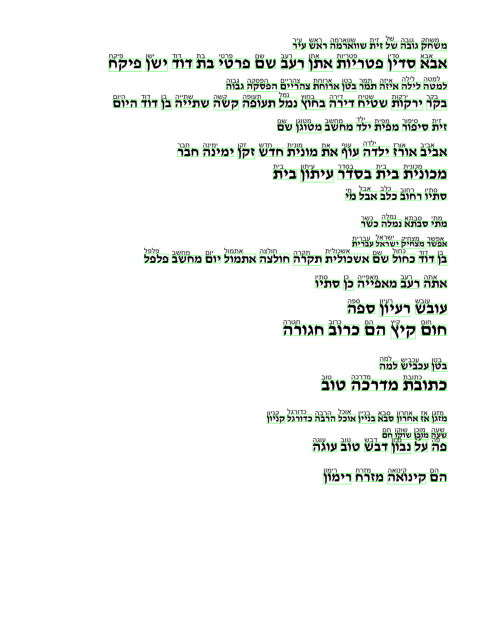

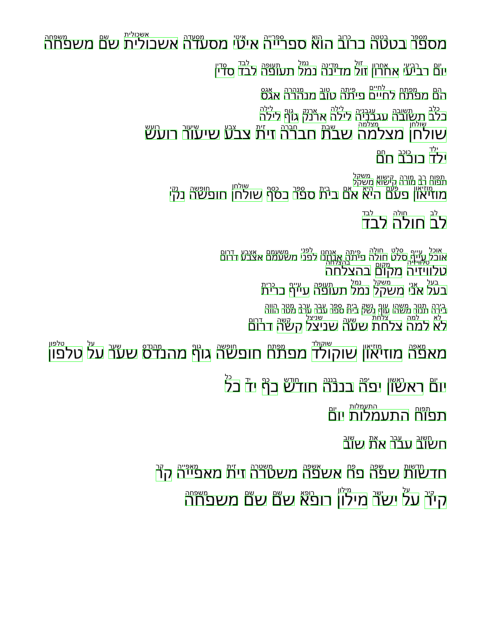

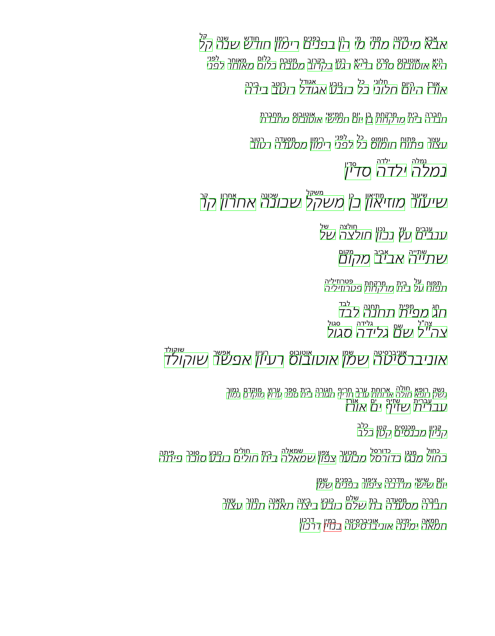

different length of words in prediction and GT, probably a word got missed/ split, handaling different length will be implemented soon


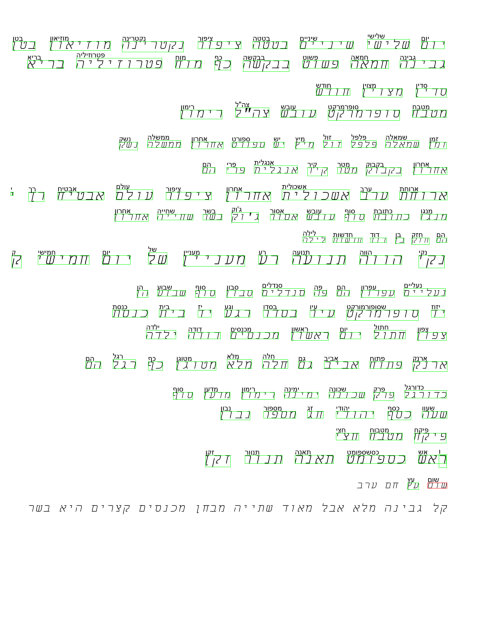

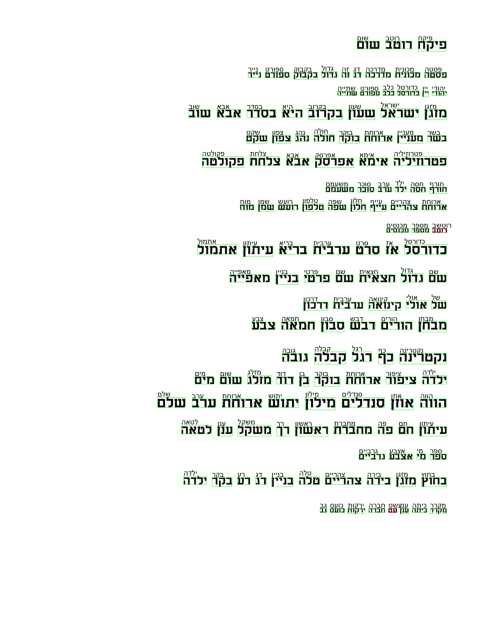

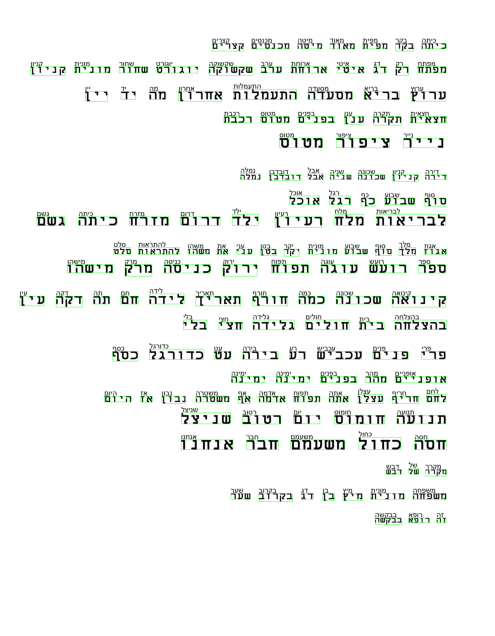

different length of words in prediction and GT, probably a word got missed/ split, handaling different length will be implemented soon


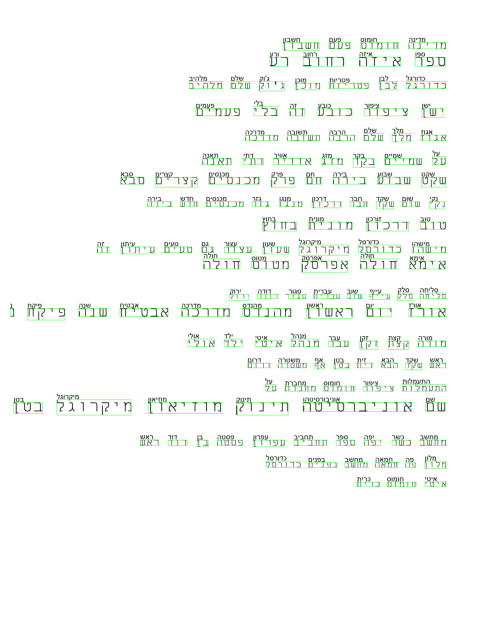

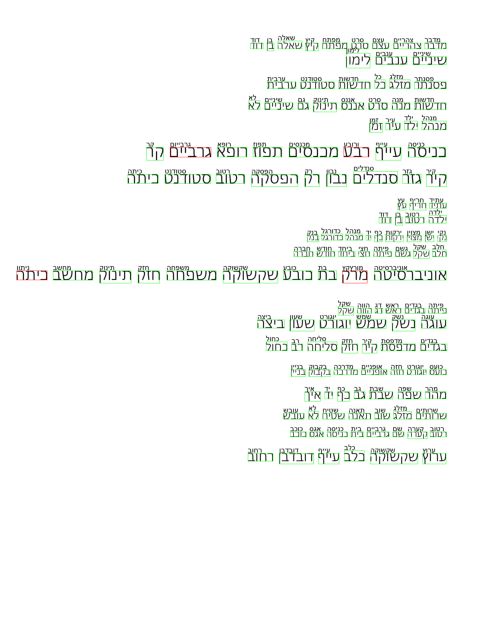

different length of words in prediction and GT, probably a word got missed/ split, handaling different length will be implemented soon


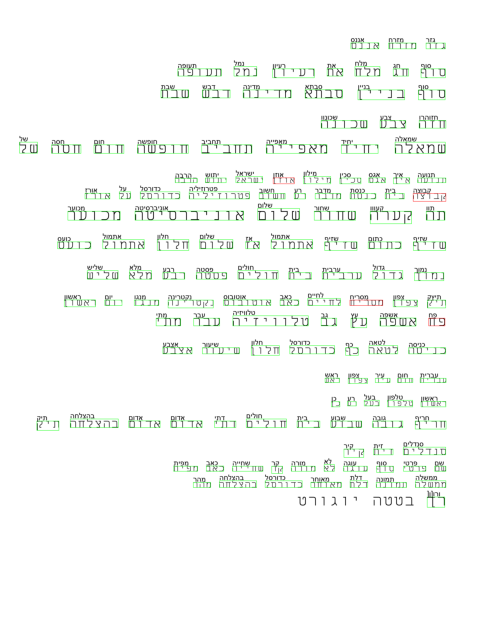

AvgWER               0.009885
AvgCER               0.005533
AvgBBoxError       141.846787
AvgConfAwareWER      0.005708
AvgConfAwareCER      0.003150
word_count         135.001647
dtype: float64


In [78]:
from glob import glob
import os.path as osp
import json
if eval_model:
    results = []
    verbose=True
    for p in glob(osp.join(eval_data_dir,'*output_data.json')):
        with open(p, encoding="utf-8") as f:
            document_data = json.load(f)
            for page, page_data in document_data.items():
                image_data_pred = pytesseract.image_to_data(page_data['image_path'],output_type=pytesseract.Output.DICT,lang=model_name)
                image_data_pred = pd.DataFrame(image_data_pred)
                image_data_pred['bbox'] = image_data_pred.apply(lambda r: (r['left'],r['top'],r['left'] + r['width'] ,r['top'] + r['height']),axis=1)
                image_data_pred  = image_data_pred[image_data_pred['conf']!=-1]
                gt_bbox = page_data['bboxes']
                gt_text = page_data['words']
                pred_bbox = list(image_data_pred['bbox'])
                pred_text = list(image_data_pred['text'])
                pred_conf = list(image_data_pred['conf'])
                try:
                    batch_results = evaluate_ocr_batch(pred_text, gt_text, pred_bbox, gt_bbox, pred_conf)
                except Exception as e:
                    print(e)
                results.append(batch_results)
                if verbose:
                    image = cv2.imread(page_data['image_path'])
                    img_rgb = visualize_ocr_utf8(image, pred_bbox, pred_text,wers = batch_results['WERs'],font_size=40)
                    # Display the image
                    plt.figure(figsize=(12, 8))
                    plt.imshow(img_rgb)
                    plt.axis('off')
                    plt.show()

    results = pd.DataFrame(results*10)
    results['word_count'] = results['WERs'].apply(lambda x: len(x))
    stats = results[[c for c in results.columns if "Avg" in c or c=='word_count']]
    stats = stats.multiply(stats['word_count'],axis=0).sum()/stats['word_count'].sum()

    print(stats)